## License

### Copyright (c) 2024 robert.bhero@gwu.edu, shepherd.chikwawawa@gwu.edu, pamela.chirwa@gwu.edu

## MIT License
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_rmsle(actual, predicted):
    """
    Calculate the Root Mean Squared Logarithmic Error (RMSLE).
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Ensure no negative values (for log calculations)
    actual = np.maximum(actual, 0)
    predicted = np.maximum(predicted, 0)
    
    # Apply the RMSLE formula
    rmsle = np.sqrt(np.mean((np.log1p(predicted) - np.log1p(actual))**2))
    return rmsle

# Load the training and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Separate target variable and features in training data
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

# Preprocessing and model pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define transformers for numerical and categorical data
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline that first preprocesses the data, then fits the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split training data for cross-validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on training data
y_pred_train = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_rmsle = calculate_rmsle(y_train, y_pred_train)

# Evaluate the model on validation data
y_pred_val = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
val_rmsle = calculate_rmsle(y_val, y_pred_val)

# Add Kaggle public score
kaggle_public_score = 0.1512  # Provided by Kaggle submission

# Display metrics neatly
metrics = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test (Kaggle)'],
    'RMSE': [train_rmse, val_rmse, None],
    'MAE': [train_mae, val_mae, None],
    'R-Squared': [train_r2, val_r2, None],
    'RMSLE': [train_rmsle, val_rmsle, kaggle_public_score]
})
print(metrics)

# Predict on the test dataset
X_test = test_data.drop(['Id'], axis=1)
test_predictions = model.predict(X_test)

# Save the submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions
})
submission.to_csv('Submission.csv', index=False)
print("Submission file saved as 'Submission.csv'.")

         Dataset          RMSE           MAE  R-Squared     RMSLE
0       Training  11164.323415   6553.593562   0.979103  0.059629
1     Validation  28775.416959  17519.763630   0.892048  0.153726
2  Test (Kaggle)           NaN           NaN        NaN  0.151200
Submission file saved as 'Submission.csv'.


# Correlation Heatman

A heatmap is a graphical representation of data where individual values are represented by varying colors. Heatmaps are widely used for analyzing relationships and feature importance.

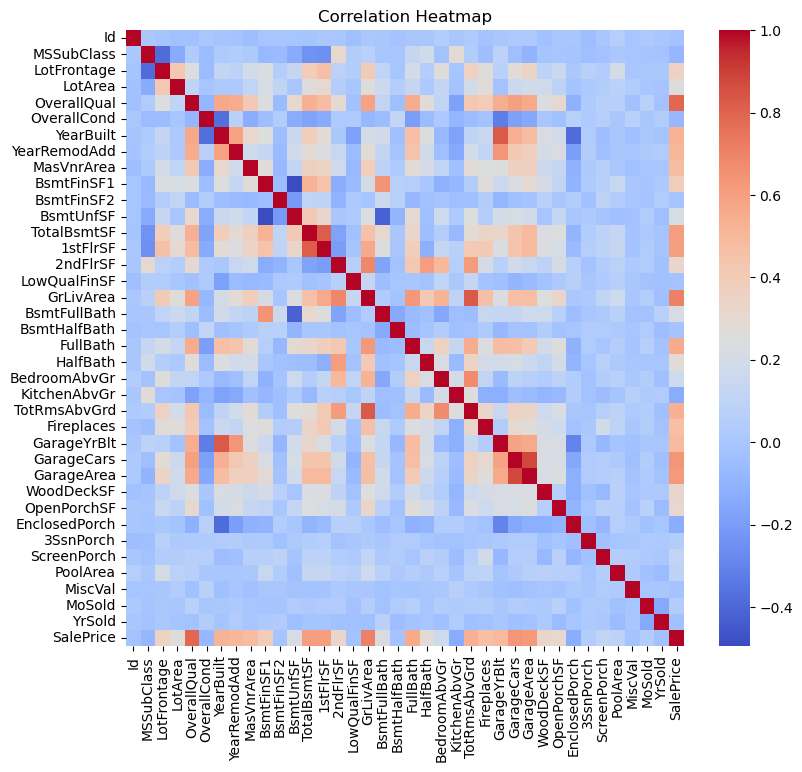

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training dataset
train_data = pd.read_csv('train.csv')

# Select only numeric columns
numeric_data = train_data.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Draw the heatmap without numbers
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Feature Importance
Visualising which features are most important in predicting the target

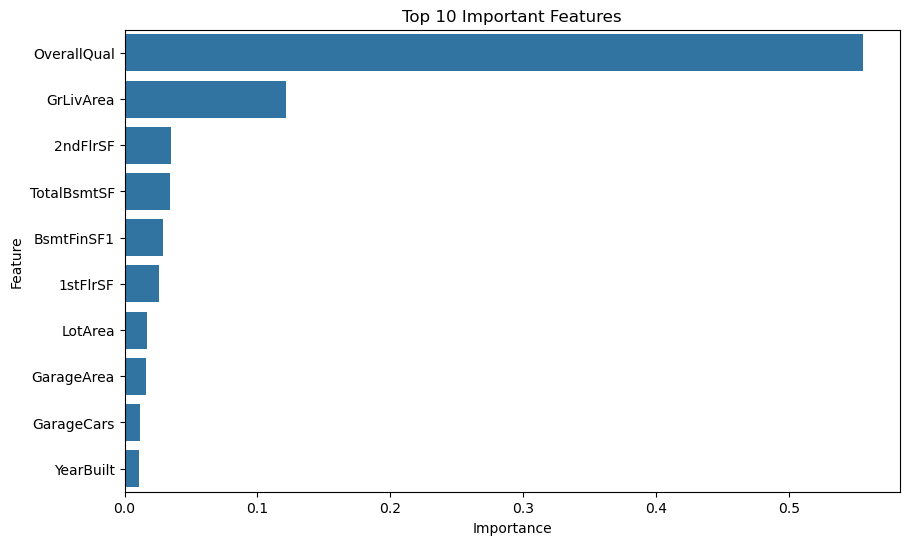

In [15]:
# Extract feature importance from the Random Forest model
feature_importances = model.named_steps['regressor'].feature_importances_
feature_names = numeric_features.tolist() + \
                list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Actual vs. Predicted
Visualize how well the model's predictions align with the actual values for the validation set.

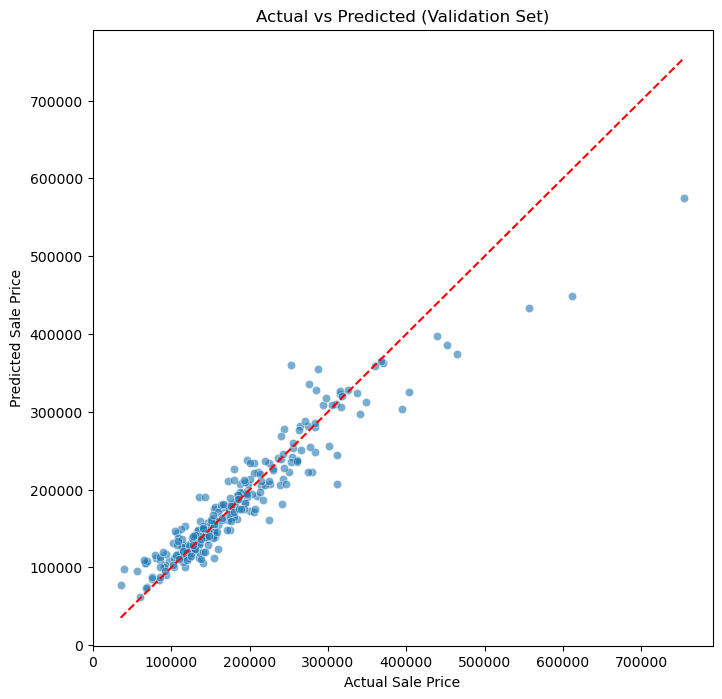

In [17]:
# Scatter plot for actual vs predicted
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Perfect prediction line
plt.title('Actual vs Predicted (Validation Set)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()


# Residuals

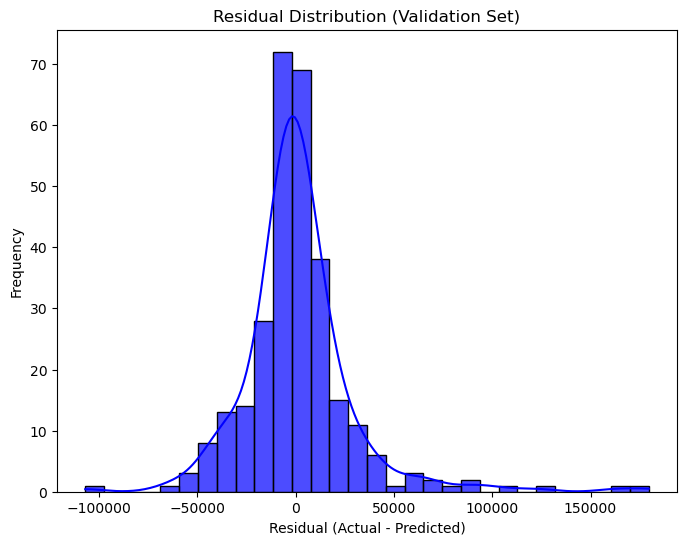

In [19]:
# Calculate residuals
residuals = y_val - y_pred_val

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.7)
plt.title('Residual Distribution (Validation Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()


# Distribution of Sale Prices
Visualising the distribution of the target variable to understand its spread and skewness

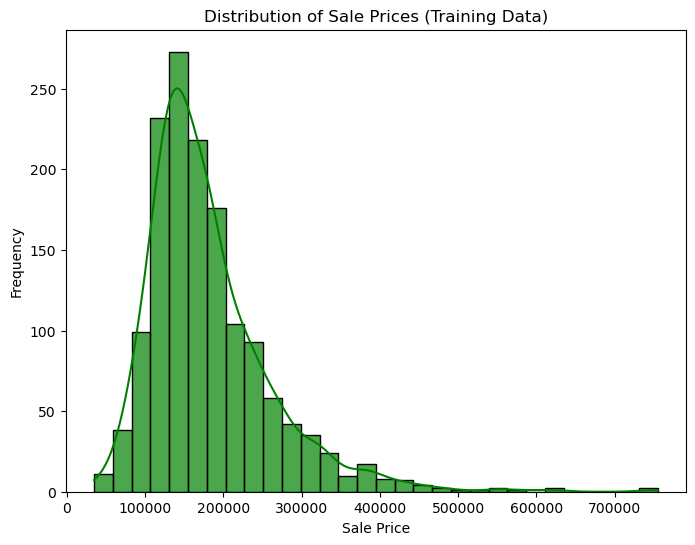

In [21]:
# Plot SalePrice distribution
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Sale Prices (Training Data)')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()